### Importing necessary libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import norm
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('breast_cancer_wisconsin.csv')

### Dataset analysis and looking for missing values

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
#df.info()

In [5]:
#df.describe()

In [6]:
#df.isnull().sum()

In [7]:
df = df.drop(['Unnamed: 32', 'id'],axis = 1)

### Dividing data into features and missing values and labeling them

In [8]:
from sklearn.preprocessing import LabelEncoder

In [9]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [10]:
le = LabelEncoder()
y = le.fit_transform(y)

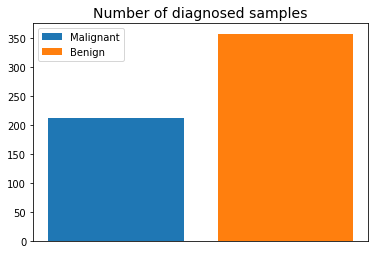

In [11]:
M = df[df['diagnosis'] == 'M']
B = df[df['diagnosis'] == 'B']
plt.bar(1, len(M))
plt.bar(2, len(B))
plt.xticks([])
plt.legend(['Malignant', 'Benign'], loc = 'upper left')
plt.title('Number of diagnosed samples', fontsize = 14)
plt.show()

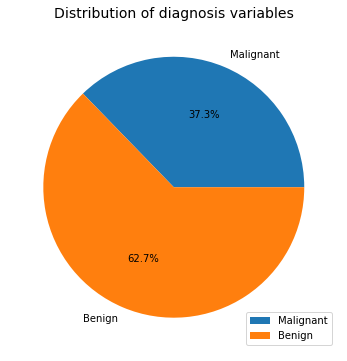

In [12]:
plt.figure(figsize = (6, 6))
plt.pie([len(M), len(B)], labels = ['Malignant', 'Benign'], autopct = '%1.1f%%')
plt.legend(['Malignant', 'Benign'], loc = 'lower right')
plt.title('Distribution of diagnosis variables', fontsize = 14)
plt.show()

### Dividing data into training and testing datasets

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

### Data standardization

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

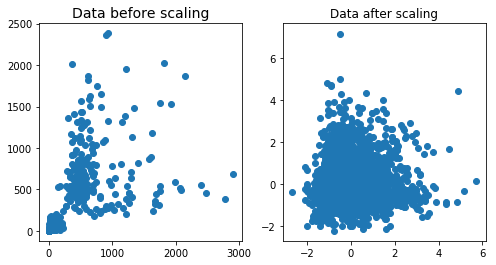

In [17]:
plt.figure(figsize = (8, 4))
plt.subplot(121)
plt.scatter(X_train[:100], X_test[:100])
plt.title('Data before scaling', fontsize = 14)

plt.subplot(122)
plt.scatter(X_train_std[:100], X_test_std[:100])
plt.title('Data after scaling')

plt.show()

### Dalsza eksploracja danych

In [18]:
def plot_distribution(feature, bins_size = 10):
    
    M_feature = sorted(M[feature])
    B_feature = sorted(B[feature])
    
    M_gaus = norm.pdf(M_feature, np.mean(M_feature), np.std(M_feature))
    B_gaus = norm.pdf(B_feature, np.mean(B_feature), np.std(M_feature))
    
    plt.hist(M_feature, alpha = 0.7, bins = bins_size, normed = True, color = 'b')
    plt.plot(M_feature, M_gaus, color = 'b')
    
    plt.hist(B_feature, alpha = 0.7, bins = bins_size, normed = True, color = 'orange')
    plt.plot(B_feature, B_gaus, color = 'orange')
    
    plt.legend(['Malignant', 'Benign'], loc = 'best')
    plt.title('Rozklad normalny dla cechy: ' + feature, fontsize = 14)
    

In [19]:
#plot_distribution('radius_mean', 5)

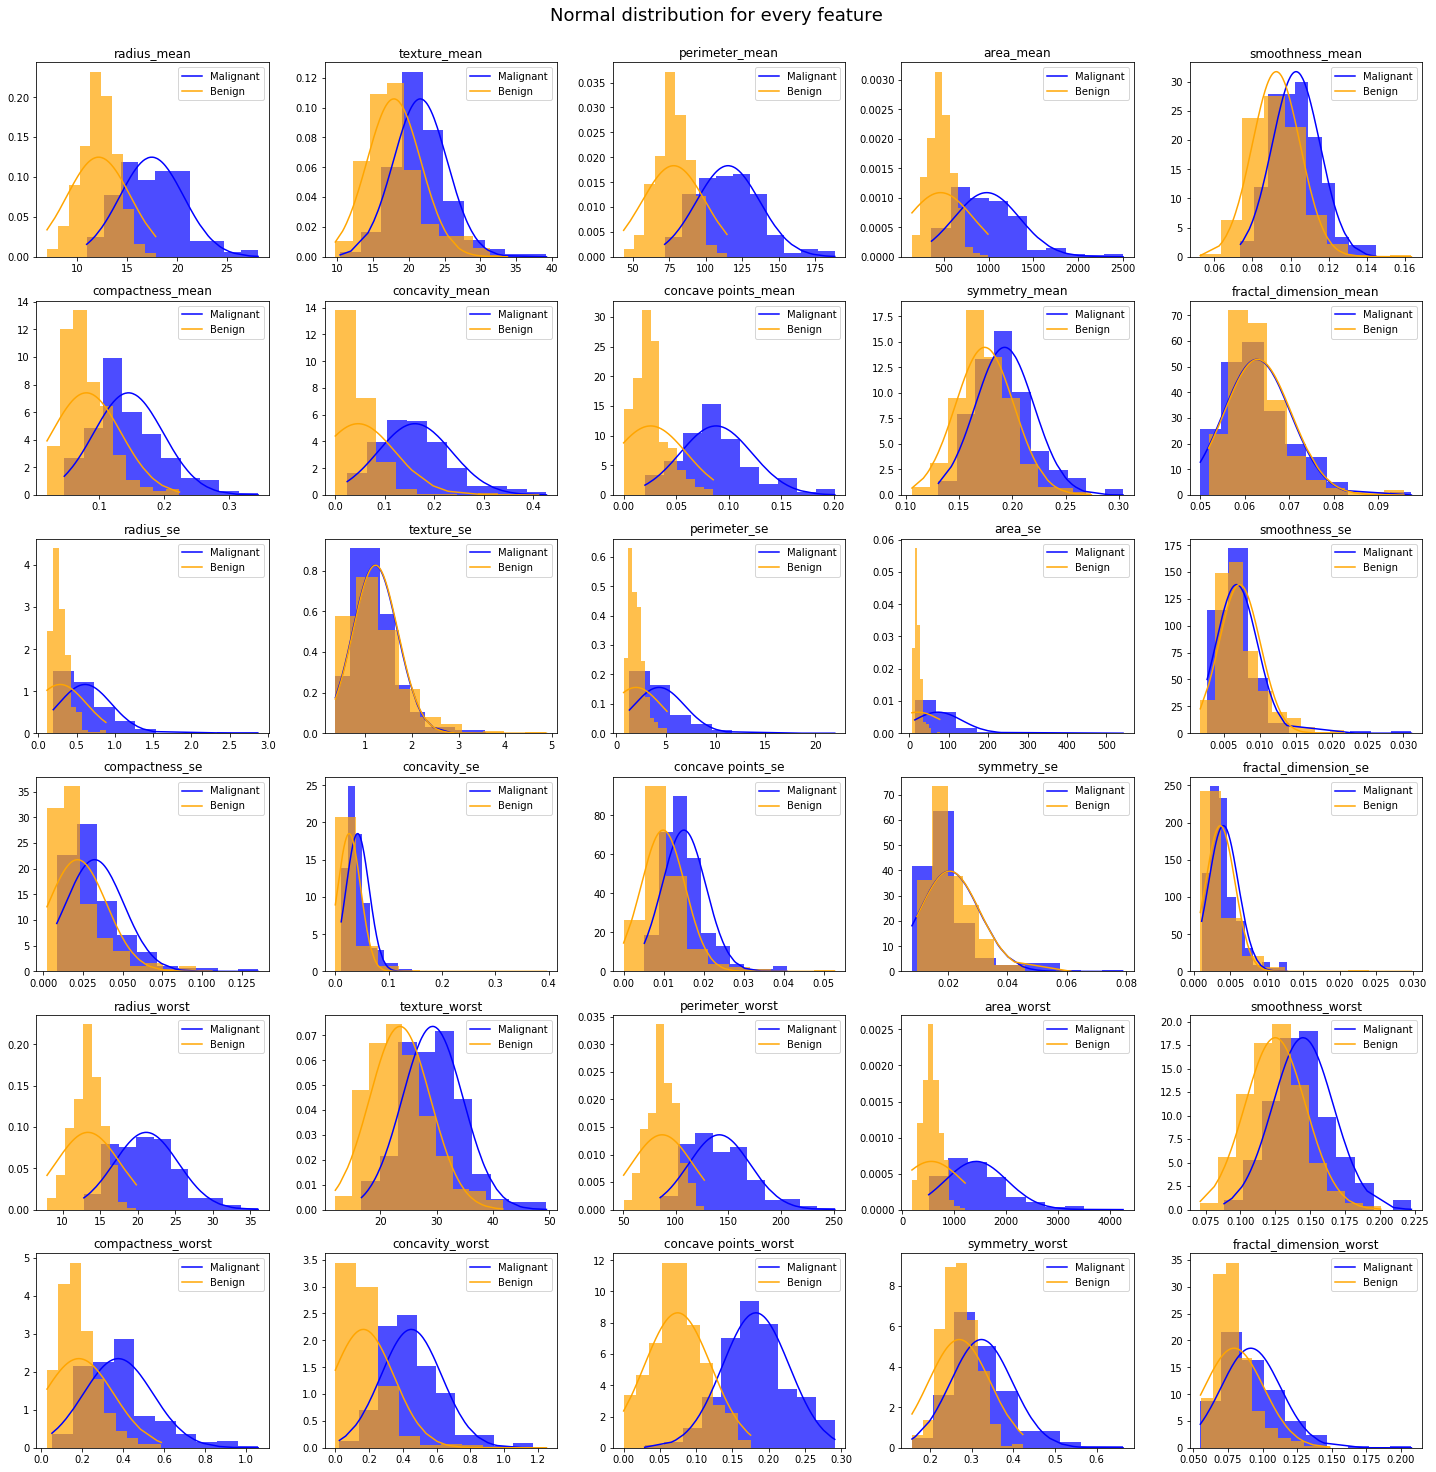

In [20]:
plt.figure(figsize = (20, 20))
for ax, feat in zip(range(1,31), df.columns[1:]):
    plt.subplot(6, 5, ax)
    plot_distribution(feat)
    plt.title(feat)

plt.suptitle(t = 'Normal distribution for every feature', x = 0.5, y = 1.02, fontsize = 18)
plt.tight_layout()
plt.show()

In [21]:
ar = df.iloc[1:]
corr_matrix = ar.corr()

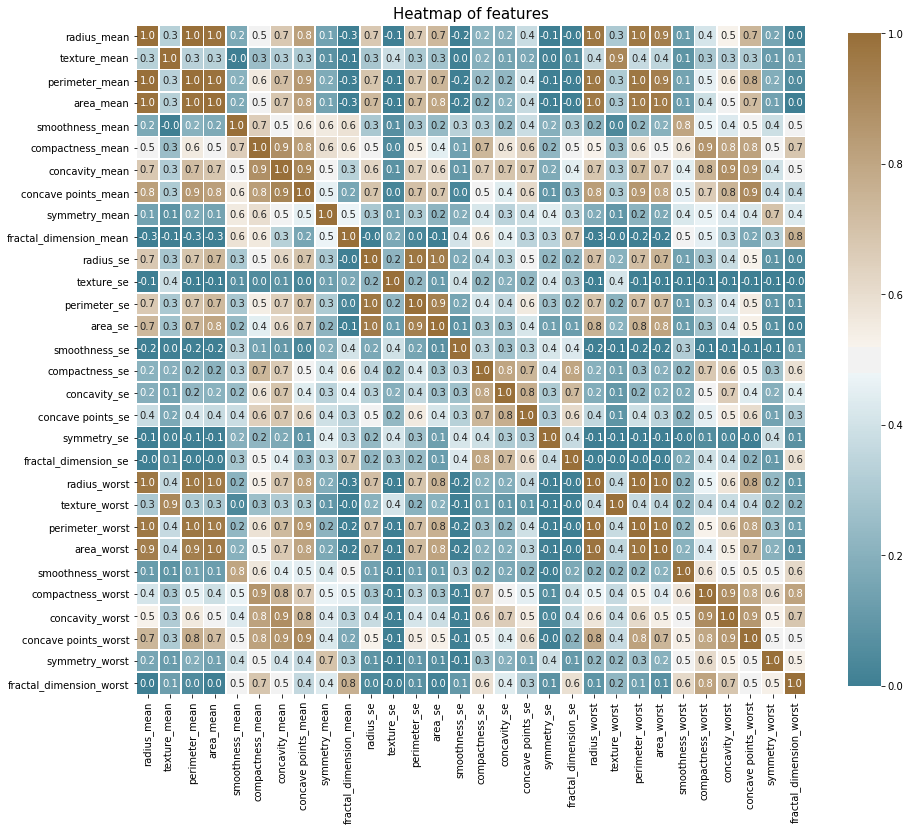

In [22]:
fig, ax = plt.subplots(figsize = (15,15))

cmap = sns.diverging_palette(220, 50, as_cmap=True)

sns.heatmap(corr_matrix, cmap=cmap, vmin = 0, vmax = 1,
            square=True, linewidths=0.8, cbar_kws = {'shrink': 0.8}, annot = True, fmt = '.1f')

plt.title('Heatmap of features', fontsize = 15, y = 1.02)
plt.show()

In [23]:
def sct1_sct2(feat1, feat2):
    
    xM_feature = M[feat1]
    yM_feature = M[feat2]
    
    plt.scatter(xM_feature, yM_feature, color = 'b')
    
    xB_feature = B[feat1]
    yB_feature = B[feat2]
    
    plt.scatter(xB_feature, yB_feature, color = 'orange')
    
    plt.xlabel(feat1)
    plt.ylabel(feat2)
    plt.legend(['Malignant', 'Benign'], loc = 'best')
    plt.title(feat1 + ' vs ' + feat2, fontsize = 12)
    plt.tight_layout()

#### Examples of positive corellation

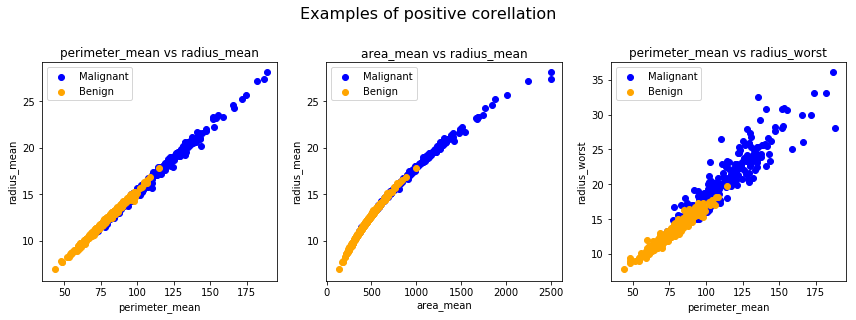

In [24]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(131)
sct1_sct2('perimeter_mean', 'radius_mean')

plt.subplot(132)
sct1_sct2('area_mean', 'radius_mean')

plt.subplot(133)
sct1_sct2('perimeter_mean', 'radius_worst')

plt.suptitle(t = 'Examples of positive corellation', x = 0.5, y = 1.1, fontsize = 16)
plt.show()

#### Examples of the lack of corellation

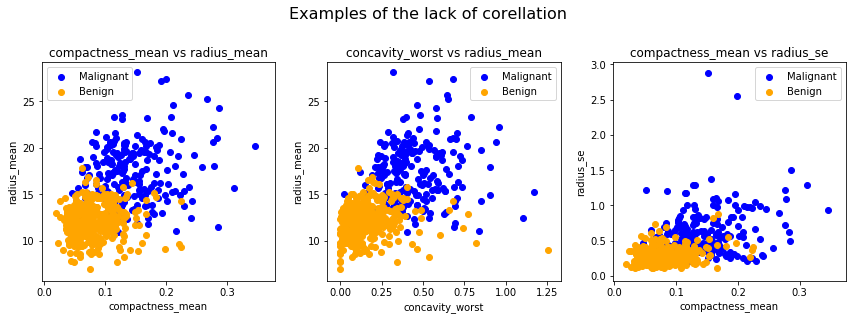

In [25]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(131)
sct1_sct2('compactness_mean', 'radius_mean')

plt.subplot(132)
sct1_sct2('concavity_worst', 'radius_mean')

plt.subplot(133)
sct1_sct2('compactness_mean', 'radius_se')

plt.suptitle(t = 'Examples of the lack of corellation', x = 0.5, y = 1.1, fontsize = 16)
plt.show()

#### Examples of negative corellation

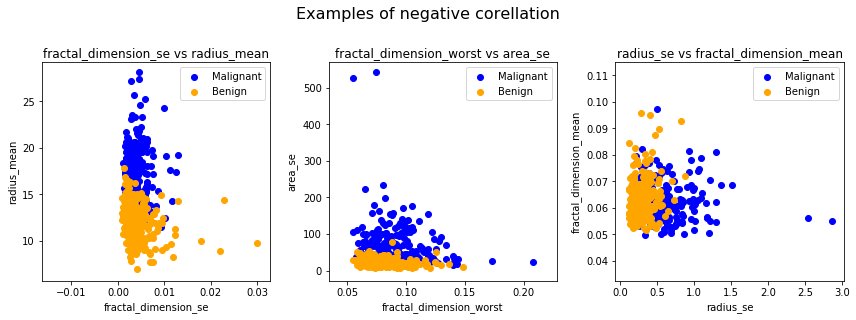

In [26]:
fig = plt.figure(figsize = (12, 4))

plt.subplot(131)
sct1_sct2('fractal_dimension_se', 'radius_mean')

plt.subplot(132)
sct1_sct2('fractal_dimension_worst', 'area_se')

plt.subplot(133)
sct1_sct2('radius_se', 'fractal_dimension_mean')

plt.suptitle(t = 'Examples of negative corellation', x = 0.5, y = 1.1, fontsize = 16)
plt.show()

### Data compression with PCA and LDA algorithms, comparison of their accuracy

#### Checking the significance of individual features on the accuracy of the model

In [27]:
pca_comp = PCA(n_components = None)
X_train_pca = pca_comp.fit_transform(X_train_std)
X_test_pca = pca_comp.transform(X_test_std)

In [28]:
cum_var_exp = np.cumsum(pca_comp.explained_variance_ratio_)

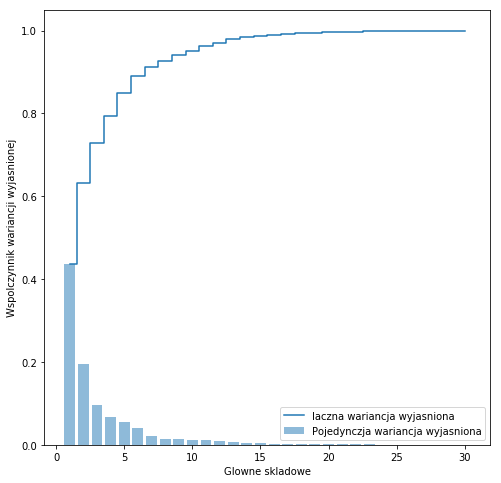

In [29]:
plt.figure(figsize = (8, 8))
plt.bar(range(1,31), pca_comp.explained_variance_ratio_, alpha =0.5, align = 'center', label = 'Pojedynczja wariancja wyjasniona')
plt.step(range(1,31), cum_var_exp, where='mid', label='laczna wariancja wyjasniona')
plt.ylabel('Wspolczynnik wariancji wyjasnionej')
plt.xlabel('Glowne skladowe')
plt.legend(loc = 'best')
plt.show()

In [30]:
pca = PCA(n_components = 14)         # best score for 14
lr = LogisticRegression(random_state = 0)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

#### Accuracy of a model for a dataset with all features included

In [31]:
lr.fit(X_train_std, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [32]:
prediction = lr.predict(X_test_std)

In [33]:
accuracy_score(prediction, y_test)    

0.9766081871345029

#### Accuracy of a model for a dataset after compression with PCA algorithm

In [34]:
lr2 = LogisticRegression(random_state = 0)

In [35]:
lr2.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
prediction_pca = lr2.predict(X_test_pca)

In [37]:
accuracy_score(prediction_pca, y_test)   

0.9766081871345029

#### Accuracy of a model for a dataset after compressjion with LDA algorithm

In [38]:
lr3 = LogisticRegression(random_state = 0)
lr3.fit(X_train_lda, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [39]:
prediction_lda = lr3.predict(X_test_lda)

In [40]:
accuracy_score(prediction_lda, y_test)   

0.9649122807017544

### Comparing accuracy of diffrent models using k-fold validation

In [41]:
clfs = {'ppn' :Perceptron(),'lr': LogisticRegression(),'sgdc' : SGDClassifier(),'svm': SVC(), 
          'tree': DecisionTreeClassifier(),'knn': KNeighborsClassifier()}

Accuracy for knn is equal: 0.962 +/- 0.024
Accuracy for sgdc is equal: 0.965 +/- 0.028
Accuracy for ppn is equal: 0.968 +/- 0.034
Accuracy for svm is equal: 0.970 +/- 0.025
Accuracy for lr is equal: 0.982 +/- 0.025
Accuracy for tree is equal: 0.902 +/- 0.051


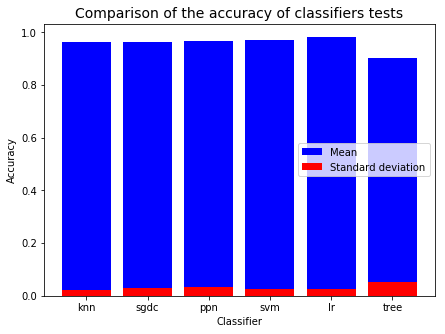

In [42]:
plt.figure(figsize = (7, 5))
for col, (key, value) in zip(np.arange(len(clfs)), clfs.items()):
    score_mdl = cross_val_score(estimator = value, X = X_train_pca, y = y_train, cv = 10, n_jobs = -1)
    
    
    b1 = plt.bar(col, np.mean(score_mdl), color = 'b')
    b2 = plt.bar(col, np.std(score_mdl), color = 'r')

    print('Accuracy for ' + key + ' is equal: %.3f +/- %.3f' % (np.mean(score_mdl), np.std(score_mdl)))
    
plt.xlabel('Classifier')   
plt.ylabel('Accuracy')
plt.title('Comparison of the accuracy of classifiers tests', fontsize = 14)
plt.legend((b1, b2), (['Mean', 'Standard deviation']), loc = 'center right')
plt.xticks(np.arange(len(clfs)), (key for key, value in clfs.items()))
plt.show()

### Diagnosing problems with bias and variance using learning curves

In [43]:
def plot_lc(est, i):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator = est, X = X_train_pca, y = y_train,
                                                            train_sizes = np.linspace(0.1, 1.0, 10), cv = 10, n_jobs = 1)
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    
    plt.subplot(3, 2, i)
    plt.plot(train_sizes, train_mean, color = 'blue', marker = 'o', markersize = 5, label = 'Training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha = 0.15, color = 'blue')
    plt.subplot(3, 2, i)
    plt.plot(train_sizes, test_mean, color = 'green', marker = 's', markersize = 5, label = 'Validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha = 0.15, color = 'green')
    plt.grid()
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.ylim(0.8, 1.05)
    plt.legend(loc = 'lower right')
    plt.title('Learning curve for ' + key)
    plt.tight_layout()

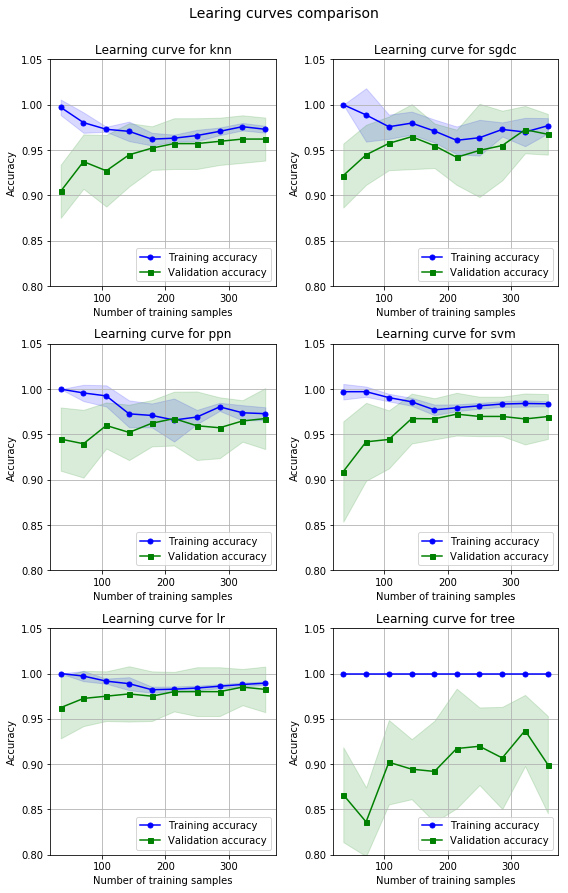

In [44]:
plt.figure(figsize = (8, 12))

for pl, (key, value) in zip(range(1, 7), clfs.items()):

    plot_lc(value, pl)
    
plt.suptitle('Learing curves comparison', x = 0.5, y = 1.03, fontsize = 14)
plt.show()

### Tuning hyperparameters using the grid search method

#### For logistic regression

In [45]:
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C' : param_range, 'penalty' : ['l1', 'l2']}]

In [46]:
gs = GridSearchCV(estimator = clfs['lr'], param_grid = param_grid, scoring = 'accuracy', cv = 10, n_jobs = -1)

In [47]:
gs = gs.fit(X_train_pca, y_train)

In [48]:
print(gs.best_score_)

0.9824120603015075


In [49]:
print(gs.best_params_)

{'C': 1.0, 'penalty': 'l1'}


In [50]:
clf_1 = gs.best_estimator_

In [51]:
clf_1.fit(X_train_pca, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
print('Test accuracy: %.3f' % clf_1.score(X_test_pca, y_test))

Test accuracy: 0.971


#### For SVM

In [53]:
param_grid_2 = [{'C' : param_range, 'kernel' : ['linear']}, {'C' : param_range, 'gamma' : param_range, 'kernel' : ['rbf']}]

In [54]:
gs_2 = GridSearchCV(estimator = clfs['svm'], param_grid = param_grid_2, scoring = 'accuracy', cv = 10, n_jobs = 1)
gs_2 = gs_2.fit(X_train_pca, y_train)

In [55]:
print(gs_2.best_score_)
print(gs_2.best_params_)

0.9849246231155779
{'gamma': 0.001, 'kernel': 'rbf', 'C': 100.0}


In [56]:
clf_2 = gs_2.best_estimator_
clf_2.fit(X_train_pca, y_train)

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [57]:
print('Test accuracy: %.3f' % clf_2.score(X_test_pca, y_test))

Test accuracy: 0.982


#### Comparison of learning curves for selected models before and after parameters tuning

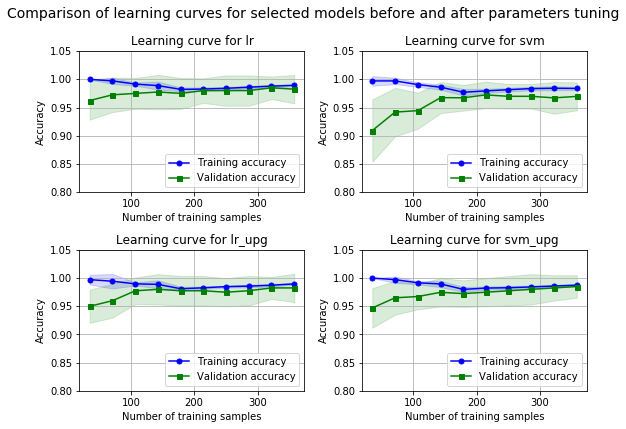

In [58]:
clfs_comp = {'svm' : SVC(), 'svm_upg' : clf_2, 'lr' : LogisticRegression(), 'svm' : SVC(), 'lr_upg' : clf_1}

plt.figure(figsize = (8, 8))

for i, (key, value) in zip(range(1,5), clfs_comp.items()):
        
    plot_lc(value, i)

plt.suptitle('Comparison of learning curves for selected models before and after parameters tuning', y = 1.03, fontsize = 14)
plt.show()

### Evaluation of the accuracy of selected models using different metrics

In [59]:
best_clfs = {'clf_1' : clf_1, 'clf_2' : clf_2}

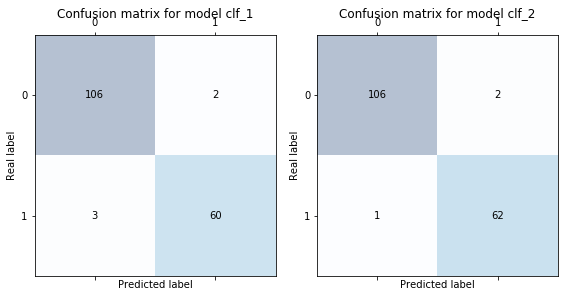

In [60]:
fig, axs = plt.subplots(1, 2, figsize = (8,5))
for ax, (key, value) in zip(axs, best_clfs.items()):
    y_pred = value.predict(X_test_pca)
    confmat = confusion_matrix(y_true = y_test, y_pred = y_pred)
    

    ax.matshow(confmat, cmap = plt.cm.Blues, alpha =0.3)
    
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y = i, s = confmat[i, j], va = 'center', ha = 'center')
            
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Real label')
    ax.set_title('Confusion matrix for model ' + key, fontsize = 12)
    
plt.tight_layout()
plt.show()
    

In [61]:
for key, value in best_clfs.items():
    
    print('Evaluated model: ' + key)
    print('Accuracy: %.3f' % accuracy_score(y_true = y_test, y_pred = value.predict(X_test_pca)))
    print('Precision: %.3f' % precision_score(y_true = y_test, y_pred = value.predict(X_test_pca)))
    print('Recall: %.3f' % recall_score(y_true = y_test, y_pred = value.predict(X_test_pca)))
    print('F1: % .3f' % f1_score(y_true = y_test, y_pred = value.predict(X_test_pca)))
    print('Area under ROC curve: %.3f' % roc_auc_score(y_true = y_test, y_score = value.predict(X_test_pca)))
    print('\n')

Evaluated model: clf_1
Accuracy: 0.971
Precision: 0.968
Recall: 0.952
F1:  0.960
Area under ROC curve: 0.967


Evaluated model: clf_2
Accuracy: 0.982
Precision: 0.969
Recall: 0.984
F1:  0.976
Area under ROC curve: 0.983




In [62]:
model_metrics = {'Logistic regression' : [0.971, 0.968, 0.952, 0.960, 0.967],
                 'SVM' : [0.982, 0.969, 0.984, 0.976, 0.983]}

In [63]:
result = pd.DataFrame(data = model_metrics)

In [64]:
result = result.rename(index = {0 : 'Accuracy', 1 : 'Precision', 2 : 'Recall', 3 : 'F1', 4 : 'AUC' })

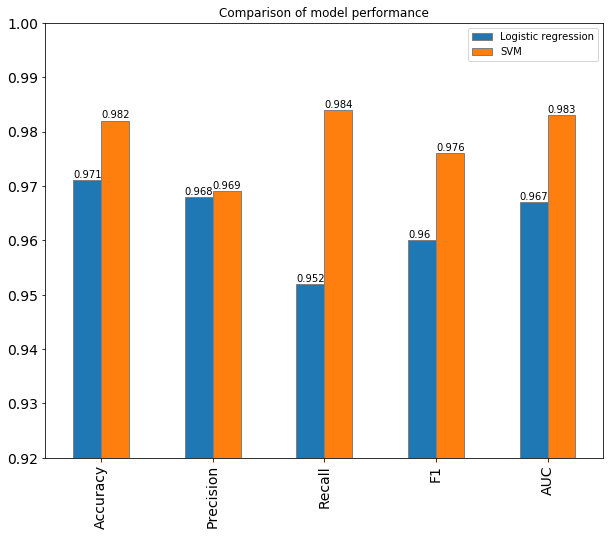

In [65]:
ax = result.plot(kind = 'bar', ylim = (0.92, 1.0), figsize = (10, 8), title = 'Comparison of model performance',
                fontsize = 14, edgecolor = 'grey')

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() , p.get_height() * 1.0005))
plt.show()